In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# For machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report
import lightgbm as lgb

# To suppress warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
train = pd.read_csv('train_new.csv')
val = pd.read_csv('val_new.csv')

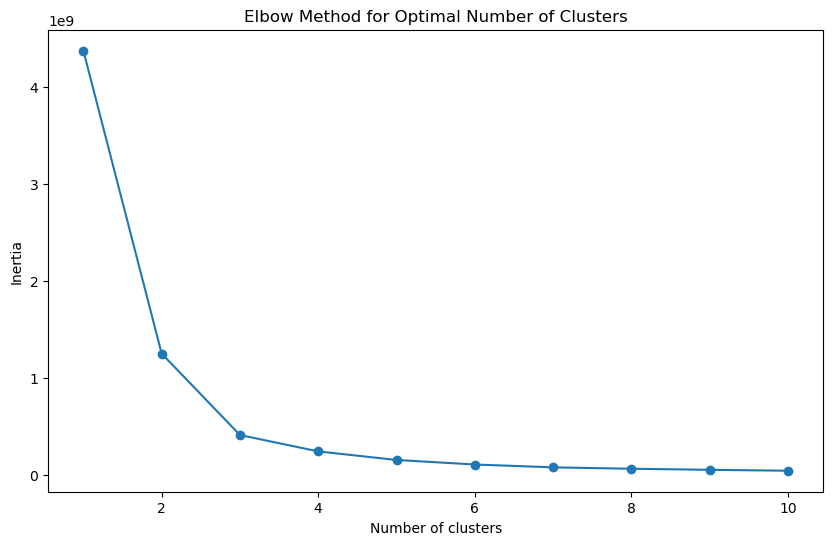

In [51]:
# import matplotlib.pyplot as plt
# from sklearn.cluster import KMeans

# # Define the range of clusters to try
# cluster_range = range(1, 11)
# inertia = []

# # Calculate inertia for each number of clusters
# for n_clusters in cluster_range:
#     kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#     kmeans.fit(train[['lon', 'lat', 'alt']])
#     inertia.append(kmeans.inertia_)

# # Plot the inertia values
# plt.figure(figsize=(10, 6))
# plt.plot(cluster_range, inertia, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Inertia')
# plt.title('Elbow Method for Optimal Number of Clusters')
# plt.show()

In [52]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
train['location_cluster'] = kmeans.fit_predict(train[['lon','lat','alt']])
val['location_cluster'] = kmeans.predict(val[['lon','lat','alt']])

In [4]:
train.dtypes

create_dt             object
mdm_object_name        int64
mdm_model_id           int64
lon                  float64
lat                  float64
alt                    int64
speed_gps            float64
direction            float64
accel_forward_nn     float64
accel_braking_nn     float64
accel_angular_nn     float64
accel_vertical_nn    float64
operation_kind_id      int64
month                  int64
day                    int64
hour                   int64
minute                 int64
second                 int64
day_of_week            int64
hour_sin             float64
hour_cos             float64
day_of_week_sin      float64
day_of_week_cos      float64
location_cluster       int32
dtype: object

In [53]:
print(train.shape)
print(val.shape)

(493215, 26)
(260111, 25)


In [54]:
# Combine training and validation data for label encoding
combined = pd.concat([train['mdm_object_name'], val['mdm_object_name']])

# Initialize the label encoder
le = LabelEncoder()

# Fit the label encoder on the combined data
le.fit(combined)

LabelEncoder()

In [55]:
train['mdm_object_name_encoded'] = le.transform(train['mdm_object_name'])
val['mdm_object_name_encoded'] = le.transform(val['mdm_object_name'])

In [56]:
# label encoding for 'mdm_model_id'
combined = pd.concat([train['mdm_model_id'], val['mdm_model_id']])
leid = LabelEncoder()
leid.fit(combined)
train['mdm_model_id_encoded'] = leid.transform(train['mdm_model_id'])
val['mdm_model_id_encoded'] = leid.transform(val['mdm_model_id'])

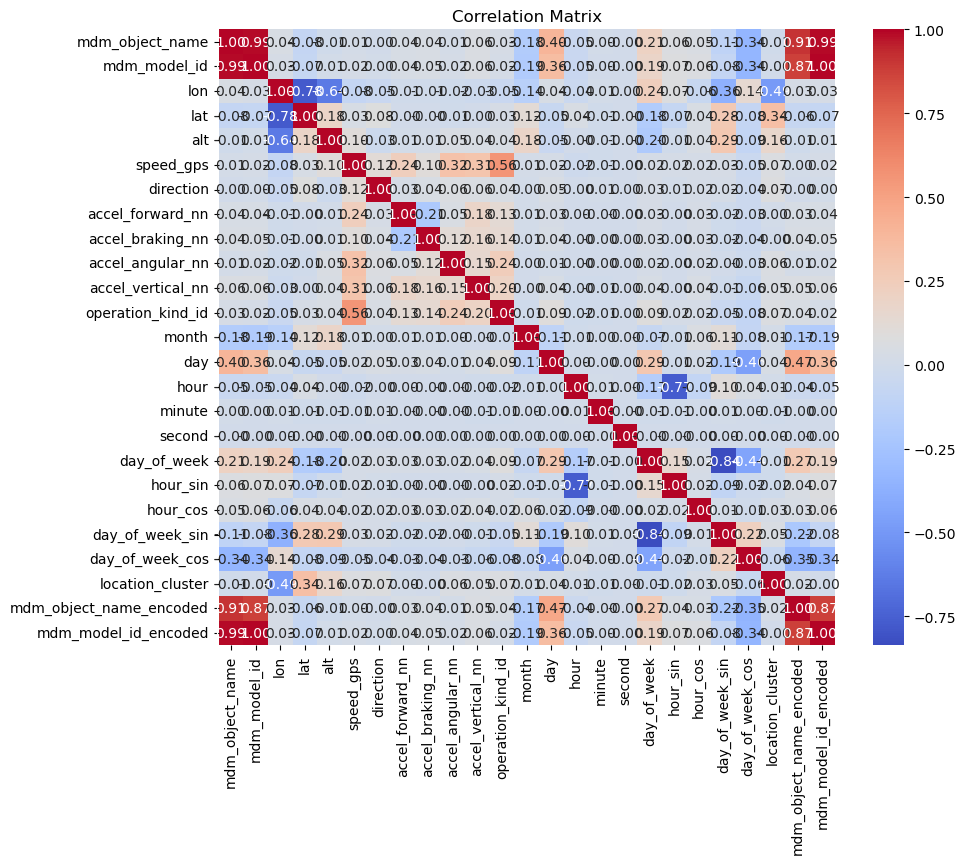

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'train' is your DataFrame
# Compute the correlation matrix
corr = train.drop(columns=['create_dt']).corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
corr

In [58]:
train.columns

Index(['create_dt', 'mdm_object_name', 'mdm_model_id', 'lon', 'lat', 'alt',
       'speed_gps', 'direction', 'accel_forward_nn', 'accel_braking_nn',
       'accel_angular_nn', 'accel_vertical_nn', 'operation_kind_id', 'month',
       'day', 'hour', 'minute', 'second', 'day_of_week', 'hour_sin',
       'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'location_cluster',
       'mdm_object_name_encoded', 'mdm_model_id_encoded'],
      dtype='object')

In [59]:
features = [ 'lon', 'lat', 'alt',
       'speed_gps', 'direction', 'accel_forward_nn', 'accel_braking_nn',
       'accel_angular_nn', 'accel_vertical_nn','day','hour_cos','location_cluster', 'day_of_week_sin']

target = 'operation_kind_id'

In [60]:
train

,create_dt,mdm_object_name,mdm_model_id,lon,lat,alt,speed_gps,direction,accel_forward_nn,accel_braking_nn,...,minute,second,day_of_week,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,location_cluster,mdm_object_name_encoded,mdm_model_id_encoded
0,2023-08-09 08:02:54,1038,62,0.005753,0.004778,-50,0.0,326.0,0.0,0.0,...,2,54,2,0.866025,-0.500000,0.974928,-0.222521,1,5,1
1,2023-08-09 08:02:59,1038,62,0.005753,0.004778,-50,0.0,326.0,0.0,0.0,...,2,59,2,0.866025,-0.500000,0.974928,-0.222521,1,5,1
2,2023-08-09 08:03:04,1038,62,0.005753,0.004778,-50,0.0,326.0,0.0,0.0,...,3,4,2,0.866025,-0.500000,0.974928,-0.222521,1,5,1
3,2023-08-09 08:03:09,1038,62,0.005753,0.004778,-50,0.0,326.0,0.0,0.0,...,3,9,2,0.866025,-0.500000,0.974928,-0.222521,1,5,1
4,2023-08-09 08:03:14,1038,62,0.005753,0.004778,-50,0.0,326.0,0.0,0.0,...,3,14,2,0.866025,-0.500000,0.974928,-0.222521,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493210,2023-12-15 15:54:26,125,61,0.007083,0.006013,-55,0.0,270.0,0.0,0.0,...,54,26,4,-0.707107,-0.707107,-0.433884,-0.900969,1,3,0
493211,2023-12-15 15:54:31,125,61,0.007083,0.006013,-55,0.0,270.0,0.0,0.0,...,54,31,4,-0.707107,-0.707107,-0.433884,-0.900969,1,3,0
493212,2023-12-15 15:54:36,125,61,0.007083,0.006013,-55,0.0,270.0,0.0,0.0,...,54,36,4,-0.707107,-0.707107,-0.433884,-0.900969,1,3,0
493213,2023-12-15 15:54:41,125,61,0.007083,0.006013,-55,0.0,270.0,0.0,0.0,...,54,41,4,-0.707107,-0.707107,-0.433884,-0.900969,1,3,0


In [61]:
x_train = train[features]
y_train = train[target]

x_train.describe()

,lon,lat,alt,speed_gps,direction,accel_forward_nn,accel_braking_nn,accel_angular_nn,accel_vertical_nn,day,hour_cos,location_cluster,day_of_week_sin
count,493215.000000,493215.000000,493215.000000,493215.000000,493215.000000,493215.000000,493215.000000,493215.000000,493215.000000,493215.000000,4.932150e+05,493215.000000,493215.000000
mean,0.000803,-0.000184,39.870691,13.617055,176.565223,0.246917,0.216133,0.426719,0.377887,16.027617,6.546305e-02,0.708081,0.057589
std,0.024045,0.010482,94.160563,10.345141,102.888061,0.545526,0.472878,0.796754,0.534920,10.788145,7.072673e-01,0.731197,0.755236
min,-0.043609,-0.027479,-146.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-1.000000e+00,0.000000,-0.974928
25%,-0.020980,-0.009962,-43.000000,0.000000,96.700000,0.000000,0.000000,0.000000,0.000000,5.000000,-7.071068e-01,0.000000,-0.433884
50%,0.007920,0.002298,55.000000,14.200000,170.900000,0.000000,0.000000,0.000000,0.000000,14.000000,6.123234e-17,1.000000,0.000000
75%,0.021485,0.008570,93.000000,20.200000,263.350000,0.196000,0.196000,0.490000,0.980000,27.000000,7.071068e-01,1.000000,0.781831
max,0.032472,0.020449,241.000000,91.000000,360.000000,5.096000,16.758000,14.406000,10.976000,30.000000,1.000000e+00,2.000000,0.974928


In [62]:
le_target = LabelEncoder()
y_train_enc = le_target.fit_transform(y_train)

In [63]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_resampled, y_resampled = smote.fit_resample(x_train, y_train_enc)

# from imblearn.over_sampling import RandomOverSampler

# # Initialize Random OverSampler
# ros = RandomOverSampler(random_state=42)

# # Apply random oversampling
# X_resampled, y_resampled = ros.fit_resample(x_train, y_train_enc)

# # Verify the resampled data
# print(f"Original dataset shape: {x_train.shape}")
# print(f"Resampled dataset shape: {X_resampled.shape}")

In [64]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# X_tr, X_val, y_tr, y_val = train_test_split(
#     x_train, y_train_enc, test_size=0.2, random_state=42, stratify=y_train_enc
# )


print("Training set size:", X_tr.shape)
print("Validation set size:", X_val.shape)


Training set size: (910096, 13)
Validation set size: (227524, 13)


In [65]:
# Example with StandardScaler
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_val_scaled = scaler.transform(X_val)

In [66]:
# # Initialize LightGBM Classifier
# model = lgb.LGBMClassifier(
#     objective='multiclass',
#     class_weight='balanced',
#     num_class=len(le_target.classes_),
#     random_state=42,
#     n_jobs=-1
# )

# # Fit the model
# model.fit(X_tr, y_tr, 
#           eval_set=[(X_val, y_val)])


In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

# Initialize Random Forest Classifier
model = RandomForestClassifier(
    n_estimators=200,  # Number of trees in the forest
    random_state=42,
    max_depth=7,
    n_jobs=-1,
    min_samples_split=5,
    max_features='sqrt'
)

# tscv = TimeSeriesSplit(n_splits=5)

# cv_f1_scores = cross_val_score(
#     model, X_tr, y_tr, 
#     cv=tscv, 
#     scoring='f1_weighted',
#     n_jobs=-1
# )

# mean_f1 = np.mean(cv_f1_scores)
# score = max(0, 100 * mean_f1)

# print(f"Mean Weighted F1 Score: {mean_f1:.4f}")
# print(f"Score: {score:.2f}")

# # Fit the model
model.fit(X_tr, y_tr)

# Evaluate the model on the validation set
y_val_pred = model.predict(X_val)
f1 = f1_score(y_val, y_val_pred, average='weighted')
score = max(0, 100 * f1)

print(f"Weighted F1 Score: {f1:.4f}")
print(f"Score: {score:.2f}")


Weighted F1 Score: 0.8000
Score: 80.00


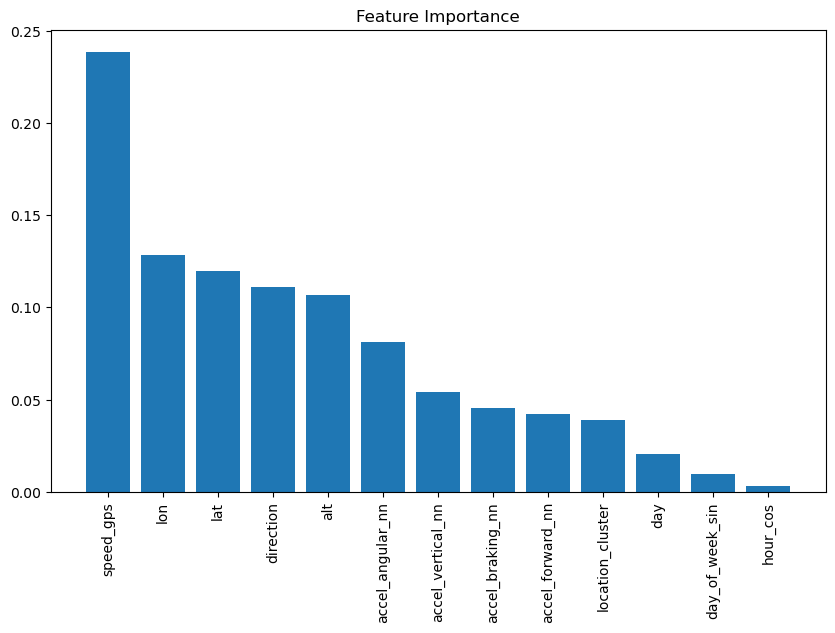

In [68]:
# Get feature importances
feature_importances = model.feature_importances_
feature_names = X_tr.columns

# Sort the feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [feature_names[i] for i in indices]

# Create plot
plt.figure(figsize=(10, 6))

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X_tr.shape[1]), feature_importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X_tr.shape[1]), names, rotation=90)

# Show plot
plt.show()

In [38]:

# # Print classification report
# print(classification_report(y_val, y_val_pred, target_names=le_target.classes_))

In [39]:
# # Plot feature importance
# import matplotlib.pyplot as plt
# import seaborn as sns

# feature_importances = pd.Series(model.feature_importances_, index=x_train.columns)
# feature_importances = feature_importances.sort_values(ascending=False)

# plt.figure(figsize=(12, 8))
# sns.barplot(x=feature_importances, y=feature_importances.index)
# plt.title('Feature Importances')
# plt.show()


In [40]:
# y_val_pred = model.predict(X_val)
# f1 = f1_score(y_val, y_val_pred, average='weighted')
# score = max(0, 100 * f1)
# print(f"Weighted F1 Score: {f1:.4f}")
# print(f"Score: {score:.2f}")


In [69]:
val = val.sort_values(['mdm_object_name', 'create_dt'])


In [70]:
val.shape

(260111, 25)

In [71]:
X_validation=val[features]

In [72]:
# Predict operational states
validation_preds = model.predict(X_validation)

# Decode labels to original operation_kind_id
validation_preds_decoded = le_target.inverse_transform(validation_preds)


In [73]:
val

,create_dt,mdm_object_name,mdm_model_id,lon,lat,alt,speed_gps,direction,accel_forward_nn,accel_braking_nn,...,minute,second,day_of_week,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,location_cluster,mdm_object_name_encoded,mdm_model_id_encoded
259303,2023-09-30 15:50:04,119,61,-0.040771,0.005671,221,0.0,69.0,0.000,0.0,...,50,4,5,-0.707107,-0.707107,-0.974928,-0.222521,2,0,0
259304,2023-09-30 15:50:09,119,61,-0.040771,0.005671,221,0.0,69.0,0.000,0.0,...,50,9,5,-0.707107,-0.707107,-0.974928,-0.222521,2,0,0
259305,2023-09-30 15:50:14,119,61,-0.040771,0.005671,221,0.0,69.0,0.000,0.0,...,50,14,5,-0.707107,-0.707107,-0.974928,-0.222521,2,0,0
259306,2023-09-30 15:50:19,119,61,-0.040755,0.005686,221,12.8,41.0,3.528,0.0,...,50,19,5,-0.707107,-0.707107,-0.974928,-0.222521,2,0,0
259307,2023-09-30 15:50:22,119,61,-0.040710,0.005743,221,12.9,23.0,3.528,0.0,...,50,22,5,-0.707107,-0.707107,-0.974928,-0.222521,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17485,2023-09-29 23:11:54,1501,62,0.028855,-0.018797,93,0.0,41.0,0.000,0.0,...,11,54,4,-0.258819,0.965926,-0.433884,-0.900969,0,19,1
17486,2023-09-29 23:11:59,1501,62,0.028855,-0.018797,93,0.0,41.0,0.000,0.0,...,11,59,4,-0.258819,0.965926,-0.433884,-0.900969,0,19,1
17487,2023-09-29 23:12:04,1501,62,0.028855,-0.018797,93,0.0,41.0,0.000,0.0,...,12,4,4,-0.258819,0.965926,-0.433884,-0.900969,0,19,1
17488,2023-09-29 23:12:09,1501,62,0.028855,-0.018797,93,0.0,41.0,0.000,0.0,...,12,9,4,-0.258819,0.965926,-0.433884,-0.900969,0,19,1


In [74]:
val.dtypes

create_dt                  datetime64[ns]
mdm_object_name                     int64
mdm_model_id                        int64
lon                               float64
lat                               float64
alt                                 int64
speed_gps                         float64
direction                         float64
accel_forward_nn                  float64
accel_braking_nn                  float64
accel_angular_nn                  float64
accel_vertical_nn                 float64
month                               int64
day                                 int64
hour                                int64
minute                              int64
second                              int64
day_of_week                         int64
hour_sin                          float64
hour_cos                          float64
day_of_week_sin                   float64
day_of_week_cos                   float64
location_cluster                    int32
mdm_object_name_encoded           

In [75]:
val['create_dt'] = pd.to_datetime(val['create_dt'])

In [76]:
val.loc[val['create_dt'].dt.time == pd.Timestamp('00:00:00').time(), 'create_dt'] #= val['create_dt'].dt.date


201253   2023-12-08
184505   2023-10-11
102168   2023-09-24
60902    2023-10-10
Name: create_dt, dtype: datetime64[ns]

In [77]:
val

,create_dt,mdm_object_name,mdm_model_id,lon,lat,alt,speed_gps,direction,accel_forward_nn,accel_braking_nn,...,minute,second,day_of_week,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,location_cluster,mdm_object_name_encoded,mdm_model_id_encoded
259303,2023-09-30 15:50:04,119,61,-0.040771,0.005671,221,0.0,69.0,0.000,0.0,...,50,4,5,-0.707107,-0.707107,-0.974928,-0.222521,2,0,0
259304,2023-09-30 15:50:09,119,61,-0.040771,0.005671,221,0.0,69.0,0.000,0.0,...,50,9,5,-0.707107,-0.707107,-0.974928,-0.222521,2,0,0
259305,2023-09-30 15:50:14,119,61,-0.040771,0.005671,221,0.0,69.0,0.000,0.0,...,50,14,5,-0.707107,-0.707107,-0.974928,-0.222521,2,0,0
259306,2023-09-30 15:50:19,119,61,-0.040755,0.005686,221,12.8,41.0,3.528,0.0,...,50,19,5,-0.707107,-0.707107,-0.974928,-0.222521,2,0,0
259307,2023-09-30 15:50:22,119,61,-0.040710,0.005743,221,12.9,23.0,3.528,0.0,...,50,22,5,-0.707107,-0.707107,-0.974928,-0.222521,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17485,2023-09-29 23:11:54,1501,62,0.028855,-0.018797,93,0.0,41.0,0.000,0.0,...,11,54,4,-0.258819,0.965926,-0.433884,-0.900969,0,19,1
17486,2023-09-29 23:11:59,1501,62,0.028855,-0.018797,93,0.0,41.0,0.000,0.0,...,11,59,4,-0.258819,0.965926,-0.433884,-0.900969,0,19,1
17487,2023-09-29 23:12:04,1501,62,0.028855,-0.018797,93,0.0,41.0,0.000,0.0,...,12,4,4,-0.258819,0.965926,-0.433884,-0.900969,0,19,1
17488,2023-09-29 23:12:09,1501,62,0.028855,-0.018797,93,0.0,41.0,0.000,0.0,...,12,9,4,-0.258819,0.965926,-0.433884,-0.900969,0,19,1


In [78]:
# Create submission dataframe
submission = pd.DataFrame({
    'create_dt':val['create_dt'],
    'mdm_object_name': val['mdm_object_name'],
    'operation_kind_id': validation_preds_decoded
})

# Set index as ["create_dt", "mdm_object_name"]
submission.set_index(['create_dt', 'mdm_object_name'], inplace=True)

# Ensure the submission has the correct size
assert submission.shape[0] == 260111, "Submission file has incorrect number of rows."

# Save to CSV
submission.to_csv('submission.csv')
